### Image Processing

In [4]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

train_dir = "/kaggle/input/mirflickr25k/mirflickr25k/mirflickr/"
output_dir = './'
# os.mkdir('hr_images/')
# os.mkdir('lr_images/')

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])

for img in os.listdir(train_dir):
    if is_image_file(img):
        img_array = cv2.imread(train_dir + img)
        img_array = cv2.resize(img_array, (128,128))
        lr_img_array = cv2.resize(img_array,(32,32))
        cv2.imwrite(output_dir+ "hr_images/" + img, img_array)
        cv2.imwrite(output_dir+ "lr_images/"+ img, lr_img_array)

In [6]:
os.listdir('./hr_images/')[0:5]

['im12456.jpg', 'im4977.jpg', 'im10460.jpg', 'im11107.jpg', 'im16738.jpg']

In [7]:
os.listdir('./lr_images/')[0:5]

['im12456.jpg', 'im4977.jpg', 'im10460.jpg', 'im11107.jpg', 'im16738.jpg']

### Import Libries

In [7]:
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

### Generator

In [9]:
### Helper Blocks

def ResidualBlock(inp):
    
    conv1 = Conv2D(64, (3,3), padding = "same")(inp)
    bn1 = BatchNormalization(momentum = 0.5)(conv1)
    prelu = PReLU(shared_axes = [1,2])(bn1)
    
    conv2 = Conv2D(64, (3,3), padding = "same")(prelu)
    bn2 = BatchNormalization(momentum = 0.5)(conv2)
    elemSum =  add([inp,bn2])
    
    return elemSum

def UpsampleBLock(inp):
    
    conv= Conv2D(256, (3,3), padding="same")(inp)
    pixelShuff = UpSampling2D( size = 2 )(conv)
    prelu = PReLU(shared_axes=[1,2])(pixelShuff)
    
    return prelu


In [10]:

### Generator Block

def Generator(gen_inp, num_res_block):
    conv1 = Conv2D(64, (9,9), padding="same")(gen_inp)
    prelu = PReLU(shared_axes=[1,2])(conv1)

    layers = prelu

    for i in range(num_res_block):
        layers =  ResidualBlock(layers)

    conv2 = Conv2D(64, (3,3), padding="same")(layers)
    bn = BatchNormalization(momentum=0.5)(conv2)
    elemSum = add([bn,prelu])

    upSample1 = UpsampleBLock(elemSum)
    upSample2 = UpsampleBLock(upSample1)

    out = Conv2D(3, (9,9), padding="same")(upSample2)

    return Model(inputs=gen_inp, outputs=out)

### Descriminator

In [11]:

### Helper Blocks

def DiscriminatorBlock(inp, filters, strides=1, bn=True):
    
    layer = Conv2D(filters, (3,3), strides = strides, padding="same")(inp)

    if bn:
        layer = BatchNormalization( momentum=0.8 )(layer)
    
    leakyrelu = LeakyReLU( alpha=0.2 )(layer)
    
    return leakyrelu


In [12]:
def Discriminator(disc_inp):

    filter_ker = 64
    
    d1 = DiscriminatorBlock(disc_inp, filter_ker , bn=False)
    d2 = DiscriminatorBlock(d1, filter_ker , strides=2)
    d3 = DiscriminatorBlock(d2,filter_ker*2)
    d4 = DiscriminatorBlock(d3, filter_ker*2, strides=2)
    d5 = DiscriminatorBlock(d4, filter_ker*4)
    d6 = DiscriminatorBlock(d5, filter_ker*4, strides=2)
    d7 = DiscriminatorBlock(d6, filter_ker*8)
    d8 = DiscriminatorBlock(d7, filter_ker*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(filter_ker*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_inp, validity)

### VGG Loss

In [13]:
### Import VGG-19
from keras.applications.vgg19 import VGG19

### Pretained VGG-19 for feature extraction
def Vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

### Combined Model (Generator + Discriminator)

In [14]:
def CombinedModel(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

### Image Loading

In [6]:
### Loading 5k images for training

n=5000
lr_list = os.listdir("./lr_images")[:n]
hr_list = os.listdir("./hr_images")[:n]

lr_images = []
hr_images = []
for lr_img,hr_img in zip(lr_list, hr_list):
    img_lr = cv2.imread("./lr_images/" + lr_img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    img_hr = cv2.imread("./hr_images/" + hr_img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

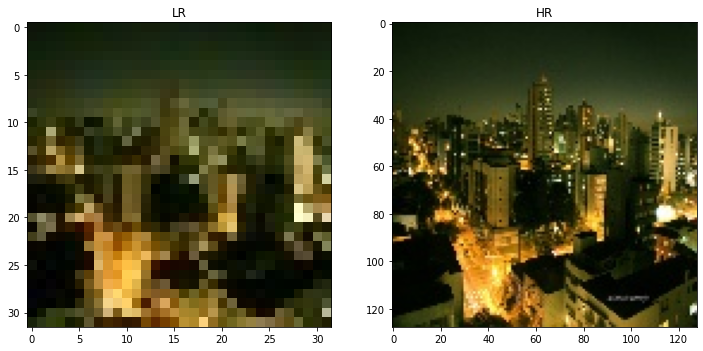

In [16]:
### Checking images

import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.title('LR')
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.title('HR')
plt.show()

### Train-Test Splitting

In [8]:

### Train-Test Split
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)


### Low & High Res shapes
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

### Low & High Res inputlayer
lr_inp = Input(shape=lr_shape)
hr_inp = Input(shape=hr_shape)

### GAN

In [18]:
### Genaraotr
generator = Generator(lr_inp, num_res_block = 16)
generator.summary()

### Discriminator
discriminator = Discriminator(hr_inp)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

### VGG
vgg = Vgg((128,128,3))
vgg.summary()
vgg.trainable = False

gan_model = CombinedModel(generator, discriminator, vgg, lr_inp, hr_inp)

2022-07-03 11:23:34.632401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 11:23:34.746823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 11:23:34.747714: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 11:23:34.748957: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   15616       input_1[0][0]                    
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 32, 32, 64)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   36928       p_re_lu[0][0]                    
______________________________________________________________________________________________

In [20]:
### GAN Model
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 128, 128, 3)  2044291     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 1)            38249281    model[0][0]                      
____________________________________________________________________________________________

### Batching & Training

In [19]:

### Creating images batches
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for img in range(int(hr_train.shape[0] / batch_size)):
    start_idx = img * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [ ]:

### Training Loop
EPOCHS = 50

for e in range(EPOCHS):
    
    fake_label = np.zeros((batch_size, 1)) # Assigning a label of 0 to all generated images
    real_label = np.ones((batch_size,1)) # Assigning a label of 1 to all real images
    
    g_losses = []
    d_losses = []
    

    for batch in tqdm(range(len(train_hr_batches))):
        
        #Fetching a batch of LR and HR images for training
        lr_imgs = train_lr_batches[batch] 
        hr_imgs = train_hr_batches[batch]
        
        fake_imgs = generator.predict_on_batch(lr_imgs)
        
        #Training of the discriminator on fake and real HR images
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Training on the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Averageing the discriminator loss, for reporting purposes
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extracting VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Training of the generator via GAN. 
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        

    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #The average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Reporting of the progress 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    #Saving the generator after every 10 epochs
    if (e+1) % 10 == 0:
        generator.save("gen_e_"+ str(e+1) +".h5")

  0%|          | 0/3350 [00:00<?, ?it/s]2022-07-03 11:24:29.908924: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-03 11:24:30.945341: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
100%|██████████| 3350/3350 [07:06<00:00,  7.85it/s]


epoch: 1 g_loss: 630880.6307672574 d_loss: [1.10827618 0.75074627]


  3%|▎         | 112/3350 [00:13<08:49,  6.11it/s]2022-07-03 11:31:50.309026: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-03 11:31:50.329447: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 3350/3350 [06:52<00:00,  8.13it/s]


epoch: 2 g_loss: 504769.0231926306 d_loss: [0.29436469 0.97268657]


  5%|▌         | 182/3350 [00:22<07:07,  7.42it/s]2022-07-03 11:38:50.802148: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-03 11:38:50.822193: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 3350/3350 [06:53<00:00,  8.10it/s]


epoch: 3 g_loss: 474231.09992945427 d_loss: [0.1606159  0.98776119]


 47%|████▋     | 1562/3350 [03:12<05:56,  5.02it/s]2022-07-03 11:48:34.586714: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-03 11:48:34.610508: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 62%|██████▏   | 2084/3350 [04:16<02:51,  7.37it/s]2022-07-03 11:49:38.910322: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-03 11:49:38.955267: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 86%|████████▌ | 2879/3350 [05:55<01:10,  6.71it/s]2022-07-03 11:51:17.231628: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-03 11:51:17.251284: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 3350/3350 [06:53<00:00,  8.10it/

epoch: 4 g_loss: 964978.715572528 d_loss: [0.03407735 0.9961194 ]


100%|██████████| 3350/3350 [06:52<00:00,  8.12it/s]


epoch: 5 g_loss: 487508.44332147855 d_loss: [0.03659921 0.99746269]


100%|██████████| 3350/3350 [06:51<00:00,  8.14it/s]


epoch: 6 g_loss: 457898.58909223415 d_loss: [0.04418183 0.99701493]


 12%|█▏        | 401/3350 [00:49<05:52,  8.37it/s]2022-07-03 12:06:49.291694: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-03 12:06:49.314032: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 3350/3350 [06:54<00:00,  8.09it/s]


epoch: 7 g_loss: 446137.8023268423 d_loss: [0.02186793 0.9980597 ]


100%|██████████| 3350/3350 [06:53<00:00,  8.10it/s]


epoch: 8 g_loss: 453265.55827367073 d_loss: [0.08476857 0.99626866]


 39%|███▉      | 1303/3350 [02:42<07:28,  4.56it/s]2022-07-03 12:22:29.886895: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-03 12:22:29.914480: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 3350/3350 [06:53<00:00,  8.11it/s]


epoch: 9 g_loss: 447328.53590951493 d_loss: [0.01177033 0.99895522]


100%|██████████| 3350/3350 [06:54<00:00,  8.09it/s]
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch: 10 g_loss: 440116.86312325095 d_loss: [0.05292806 0.99761194]


100%|██████████| 3350/3350 [06:46<00:00,  8.23it/s]


epoch: 11 g_loss: 406085.69508162315 d_loss: [5.25236991e-05 1.00000000e+00]


 65%|██████▍   | 2173/3350 [04:29<02:29,  7.88it/s]2022-07-03 12:44:51.341734: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-03 12:44:51.388499: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 76%|███████▌  | 2534/3350 [05:14<02:41,  5.06it/s]2022-07-03 12:45:35.921590: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-03 12:45:35.947946: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 3350/3350 [06:53<00:00,  8.11it/s]


epoch: 12 g_loss: 400796.9212564132 d_loss: [0.07053929 0.9980597 ]


  8%|▊         | 274/3350 [00:32<09:47,  5.24it/s]2022-07-03 12:47:47.882076: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-03 12:47:47.933919: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 3350/3350 [06:52<00:00,  8.13it/s]


epoch: 13 g_loss: 390474.7449058419 d_loss: [0.06142774 0.99820896]


 69%|██████▉   | 2327/3350 [04:42<02:46,  6.16it/s]2022-07-03 12:58:49.724836: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-03 12:58:49.760665: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 3350/3350 [06:49<00:00,  8.19it/s]


epoch: 14 g_loss: 696435.4823641558 d_loss: [0.03827961 0.9980597 ]


100%|██████████| 3350/3350 [06:53<00:00,  8.10it/s]


epoch: 15 g_loss: 456642.9902302938 d_loss: [0.00536615 0.99940299]


100%|██████████| 3350/3350 [06:53<00:00,  8.10it/s]


epoch: 16 g_loss: 403827.95961812034 d_loss: [0.03240306 0.99925373]


  7%|▋         | 228/3350 [00:28<08:39,  6.01it/s]2022-07-03 13:15:12.186589: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-03 13:15:12.222909: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 3350/3350 [06:51<00:00,  8.14it/s]


epoch: 17 g_loss: 715064.5232952426 d_loss: [0.0780487  0.99835821]


100%|██████████| 3350/3350 [06:52<00:00,  8.12it/s]


epoch: 18 g_loss: 467435.1191849347 d_loss: [9.49053152e-24 1.00000000e+00]


100%|██████████| 3350/3350 [06:55<00:00,  8.05it/s]


epoch: 19 g_loss: 390623.52659165114 d_loss: [1.93354721e-30 1.00000000e+00]


100%|██████████| 3350/3350 [06:50<00:00,  8.16it/s]


epoch: 20 g_loss: 857877.0126912313 d_loss: [0.10411046 0.99776119]


100%|██████████| 3350/3350 [06:50<00:00,  8.16it/s]


epoch: 21 g_loss: 392962.93782007927 d_loss: [0.03945839 0.99895522]


100%|██████████| 3350/3350 [06:47<00:00,  8.23it/s]


epoch: 22 g_loss: 371292.02059176774 d_loss: [4.40086415e-12 1.00000000e+00]


100%|██████████| 3350/3350 [06:48<00:00,  8.20it/s]


epoch: 23 g_loss: 2065390.8696455224 d_loss: [0.0420481  0.99940299]


  1%|▏         | 46/3350 [00:05<12:45,  4.32it/s]2022-07-03 14:02:47.160086: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-03 14:02:47.184512: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 26%|██▌       | 858/3350 [01:42<05:27,  7.62it/s]2022-07-03 14:04:24.108964: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-03 14:04:24.133218: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 3350/3350 [06:48<00:00,  8.19it/s]


epoch: 24 g_loss: 532324.7944158115 d_loss: [0.020203   0.99970149]


 81%|████████  | 2712/3350 [05:26<01:12,  8.79it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3350/3350 [06:51<00:00,  8.14it/s]


epoch: 29 g_loss: 402360.4409870569 d_loss: [7.49696525e-11 1.00000000e+00]


 36%|███▋      | 1219/3350 [02:26<04:07,  8.61it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 26%|██▌       | 879/3350 [01:47<07:44,  5.32it/s]2022-07-03 14:58:52.753705: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-03 14:58:52.792829: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 3350/3350 [06:57<00:00,  8.01it/s]


epoch: 37 g_loss: 396877.12932602613 d_loss: [0. 1.]


 49%|████▉     | 1643/3350 [03:17<03:12,  8.86it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3350/3350 [06:47<00:00,  8.21it/s]


epoch: 39 g_loss: 340828.1634672341 d_loss: [0.01253873 0.99970149]


100%|██████████| 3350/3350 [06:59<00:00,  7.99it/s]


epoch: 40 g_loss: 35611169.09092292 d_loss: [0.15581794 0.99910448]


 12%|█▏        | 402/3350 [00:50<07:56,  6.19it/s]2022-07-03 16:00:01.505006: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-03 16:00:01.523730: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 3350/3350 [06:55<00:00,  8.07it/s]


epoch: 41 g_loss: 757323.4733780317 d_loss: [0. 1.]


  6%|▋         | 210/3350 [00:26<08:58,  5.83it/s]2022-07-03 16:06:33.013142: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-03 16:06:33.032277: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 56%|█████▌    | 1878/3350 [03:54<03:45,  6.53it/s]2022-07-03 16:10:00.785099: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-03 16:10:00.803623: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 3350/3350 [06:50<00:00,  8.15it/s]


epoch: 42 g_loss: 564877.855858209 d_loss: [0. 1.]


100%|██████████| 3350/3350 [06:56<00:00,  8.04it/s]


epoch: 43 g_loss: 425465.9367788013 d_loss: [5.07994411e-27 1.00000000e+00]


 78%|███████▊  | 2607/3350 [05:17<02:18,  5.36it/s]2022-07-03 16:25:10.879294: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-03 16:25:10.902009: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 3350/3350 [06:49<00:00,  8.18it/s]


epoch: 44 g_loss: 394737.4127629431 d_loss: [0.10877767 0.99940299]


100%|██████████| 3350/3350 [06:48<00:00,  8.20it/s]


epoch: 45 g_loss: 3229146.6327227145 d_loss: [0.08080345 0.99925373]


 99%|█████████▊| 3300/3350 [06:55<00:07,  6.62it/s]2022-07-03 16:40:26.757131: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-03 16:40:26.796829: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 3350/3350 [07:01<00:00,  7.96it/s]


epoch: 46 g_loss: 552605.8090496735 d_loss: [6.11982664e-12 1.00000000e+00]


100%|██████████| 3350/3350 [06:56<00:00,  8.05it/s]


epoch: 47 g_loss: 410418.47992770525 d_loss: [6.0254077e-12 1.0000000e+00]


 62%|██████▏   | 2092/3350 [04:18<03:19,  6.31it/s]2022-07-03 16:51:47.823000: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-03 16:51:47.858824: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 87%|████████▋ | 2923/3350 [05:58<01:28,  4.84it/s]2022-07-03 16:53:27.624350: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-03 16:53:27.654655: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-03 16:53:27.682765: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 3350/3350 [06:51<00:00,  8.14it/s]


epoch: 48 g_loss: 434858.557838153 d_loss: [4.80210551e-12 1.00000000e+00]


 97%|█████████▋| 3253/3350 [06:43<00:14,  6.48it/s]2022-07-03 17:01:04.237724: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-03 17:01:04.256084: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 3350/3350 [06:55<00:00,  8.07it/s]


epoch: 49 g_loss: 4050249.7013660213 d_loss: [0.09047022 0.99910448]


 21%|██▏       | 719/3350 [01:26<06:22,  6.88it/s]2022-07-03 17:02:42.358952: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-03 17:02:42.378056: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 3350/3350 [06:55<00:00,  8.06it/s]


epoch: 50 g_loss: 573332.966170709 d_loss: [0.05013551 0.99955224]


 77%|███████▋  | 2563/3350 [26:22<17:17:31, 79.10s/it]

In [16]:
### Load Model

from keras.models import load_model
from numpy.random import randint

# Load previously trained model
generator = load_model('gen_e_40.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)

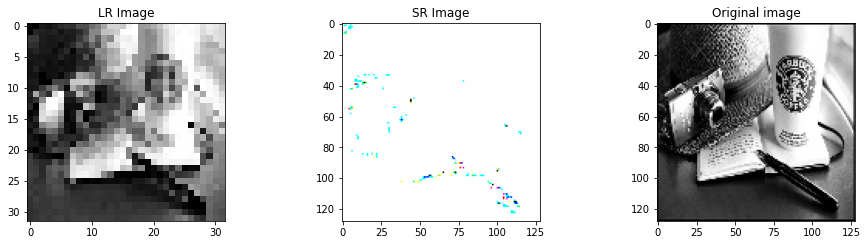

In [18]:
# plot images
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('SR Image')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Original image')
plt.imshow(tar_image[0,:,:,:])

plt.show()
